In [1]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
tf.config.set_visible_devices([], 'GPU')
# Paths
padded_cusp_image_dir = "/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/padded/images"
non_cusp_image_dir = "/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/non_cusp_images"
padded_mask_dir = "/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/padded/masks"

# Image settings
IMG_SIZE = 224  # Input size for U-Net
NUM_CLASSES = 1  # Binary segmentation (cusp vs no cusp)


# Function to load and preprocess images
def load_images(image_dir, mask_dir=None, label=1):
    images, masks = [], []

    for filename in os.listdir(image_dir):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Skipping {filename} (missing image)")
            continue

        # Resize and normalize image
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=-1)  # Add channel dimension (224, 224, 1)
        images.append(img)

        # If masks exist, load and process
        if mask_dir:
            mask_path = os.path.join(mask_dir, filename)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if mask is not None:
                mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))
                mask = mask.astype(np.float32) / 255.0
                mask = np.expand_dims(mask, axis=-1)  # Add channel dim
                masks.append(mask)
            else:
                print(f"Missing mask for {filename}")
                masks.append(np.zeros((IMG_SIZE, IMG_SIZE, 1), dtype=np.float32))
        else:
            masks.append(np.zeros((IMG_SIZE, IMG_SIZE, 1), dtype=np.float32))

    return np.array(images), np.array(masks)


# Load cusp images and masks
cusp_images, cusp_masks = load_images(padded_cusp_image_dir, padded_mask_dir)

# Load non-cusp images (with dummy zero masks)
non_cusp_images, non_cusp_masks = load_images(non_cusp_image_dir)

# Combine datasets
X = np.concatenate((cusp_images, non_cusp_images), axis=0)
y = np.concatenate((cusp_masks, non_cusp_masks), axis=0)

# Shuffle dataset
indices = np.arange(len(X))
np.random.shuffle(indices)
X, y = X[indices], y[indices]

In [2]:
def unet_model(input_size=(IMG_SIZE, IMG_SIZE, 1)):
    inputs = Input(input_size)

    # Contracting path
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    pool1 = MaxPooling2D((2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    pool2 = MaxPooling2D((2, 2))(conv2)

    # Bottleneck
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)

    # Expansive path
    up1 = UpSampling2D((2, 2))(conv3)
    concat1 = Concatenate()([up1, conv2])
    conv4 = Conv2D(128, (3, 3), activation='relu', padding='same')(concat1)

    up2 = UpSampling2D((2, 2))(conv4)
    concat2 = Concatenate()([up2, conv1])
    conv5 = Conv2D(64, (3, 3), activation='relu', padding='same')(concat2)

    # Final segmentation map
    output = Conv2D(NUM_CLASSES, (1, 1), activation='sigmoid')(conv5)

    model = Model(inputs, output)
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    return model


# Create and train model
model = unet_model()
model.summary()




Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 224, 224,  │        640 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 112, 112,  │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 112, 112,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 56, 56,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 56, 56,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d       │ (None, 112, 112,  │          0 │ conv2d_2[0][0]    │
│ (UpSampling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 112, 112,  │          0 │ up_sampling2d[0]… │
│ (Concatenate)       │ 384)              │            │ conv2d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 112, 112,  │    442,496 │ concatenate[0][0] │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_1     │ (None, 224, 224,  │          0 │ conv2d_3[0][0]    │
│ (UpSampling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 224, 224,  │          0 │ up_sampling2d_1[… │
│ (Concatenate)       │ 192)              │            │ conv2d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 224, 224,  │    110,656 │ concatenate_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 224, 224,  │         65 │ conv2d_4[0][0]    │
│                     │ 1)                │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 922,881 (3.52 MB)

 Trainable params: 922,881 (3.52 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:

history = model.fit(
    X, y,
    epochs=10,
    batch_size=32,
    validation_split=0.2
)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 64s 10s/step - accuracy: 0.9558 - loss: 0.6847 - val_accuracy: 0.9692 - val_loss: 0.6641
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 63s 10s/step - accuracy: 0.9685 - loss: 0.6510 - val_accuracy: 0.9692 - val_loss: 0.6271
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 66s 11s/step - accuracy: 0.9736 - loss: 0.6095 - val_accuracy: 0.9692 - val_loss: 0.5947
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 66s 11s/step - accuracy: 0.9745 - loss: 0.5558 - val_accuracy: 0.9692 - val_loss: 0.5219
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 67s 11s/step - accuracy: 0.9725 - loss: 0.4728 - val_accuracy: 0.9692 - val_loss: 0.3804
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 67s 11s/step - accuracy: 0.9728 - loss: 0.3142 - val_accuracy: 0.9692 - val_loss: 0.2036
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 72s 12s/step - accuracy: 0.9734 - loss: 0.1574 - val_accuracy: 0.9692 - val_loss: 0.1040
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 74s 13s/step - accuracy: 0.9710 - loss: 0.0978 - val_accuracy: 0.9692 - val_loss: 0.0854


In [4]:
model.save('Unet1.h5')

In [25]:
import numpy as np
import cv2
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import Sequence

# Paths for images and masks
padded_cusp_image_dir = "/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/padded/images"
padded_mask_dir = "/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/padded/masks"

IMG_SIZE = 224  # Fixed size for input into U-Net

# Function to load and process images
def load_images(image_dir, mask_dir=None, label=1):
    images, masks, labels = [], [], []

    for filename in os.listdir(image_dir):
        img_path = os.path.join(image_dir, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

        if img is None:
            print(f"Skipping {filename} (missing image)")
            continue

        # Resize to 224x224 or as needed for later input to the model
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        # Normalize to [0,1]
        img = img.astype(np.float32) / 255.0
        img = np.expand_dims(img, axis=-1)  # Add channel dim for CNN (e.g., (224, 224, 1))

        images.append(img)

        # If mask exists, load and process it
        if mask_dir:
            mask_path = os.path.join(mask_dir, filename)
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if mask is not None:
                mask = cv2.resize(mask, (IMG_SIZE, IMG_SIZE))  # Resize to match image size
                mask = mask.astype(np.float32) / 255.0  # Normalize to [0,1]
                mask = np.expand_dims(mask, axis=-1)  # Add channel dim (e.g., (224, 224, 1))
                masks.append(mask)
            else:
                print(f"Skipping {filename} (missing mask)")

        labels.append(label)

    return np.array(images), np.array(masks) if mask_dir else None, np.array(labels)

# Load padded cusp images and masks
cusp_images, cusp_masks, _ = load_images(padded_cusp_image_dir, padded_mask_dir)

# Data Augmentation
class AugmentedImageGenerator(Sequence):
    def __init__(self, images, masks, batch_size, img_size, augment=True):
        self.images = images
        self.masks = masks
        self.batch_size = batch_size
        self.img_size = img_size
        self.augment = augment
        self.indexes = np.arange(len(self.images))

        self.image_gen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )
        self.mask_gen = ImageDataGenerator(
            rotation_range=40,
            width_shift_range=0.2,
            height_shift_range=0.2,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True,
            fill_mode='nearest'
        )

    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]

        # Get the batch of images and masks
        batch_images = self.images[batch_indexes]
        batch_masks = self.masks[batch_indexes]

        # Apply augmentations
        if self.augment:
            batch_images = self.image_gen.random_transform(batch_images)
            batch_masks = self.mask_gen.random_transform(batch_masks)

        # Resize to the required image size (IMG_SIZE, IMG_SIZE)
        batch_images = np.array([cv2.resize(img, (self.img_size, self.img_size)) for img in batch_images])
        batch_masks = np.array([cv2.resize(mask, (self.img_size, self.img_size)) for mask in batch_masks])

        return batch_images, batch_masks

    def on_epoch_end(self):
        # Shuffle at the end of each epoch
        np.random.shuffle(self.indexes)


# Initialize the generator with images, masks, and other parameters
batch_size = 32
train_generator = AugmentedImageGenerator(cusp_images, cusp_masks, batch_size=batch_size, img_size=IMG_SIZE)




In [26]:
# Example of how to use the generator to train the model
model = unet_model()  # Your U-Net model
model.fit(train_generator, epochs=10)


/Users/rfalcao/anaconda3/envs/tf-m2/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


ValueError: Input arrays must be multi-channel 2D images.

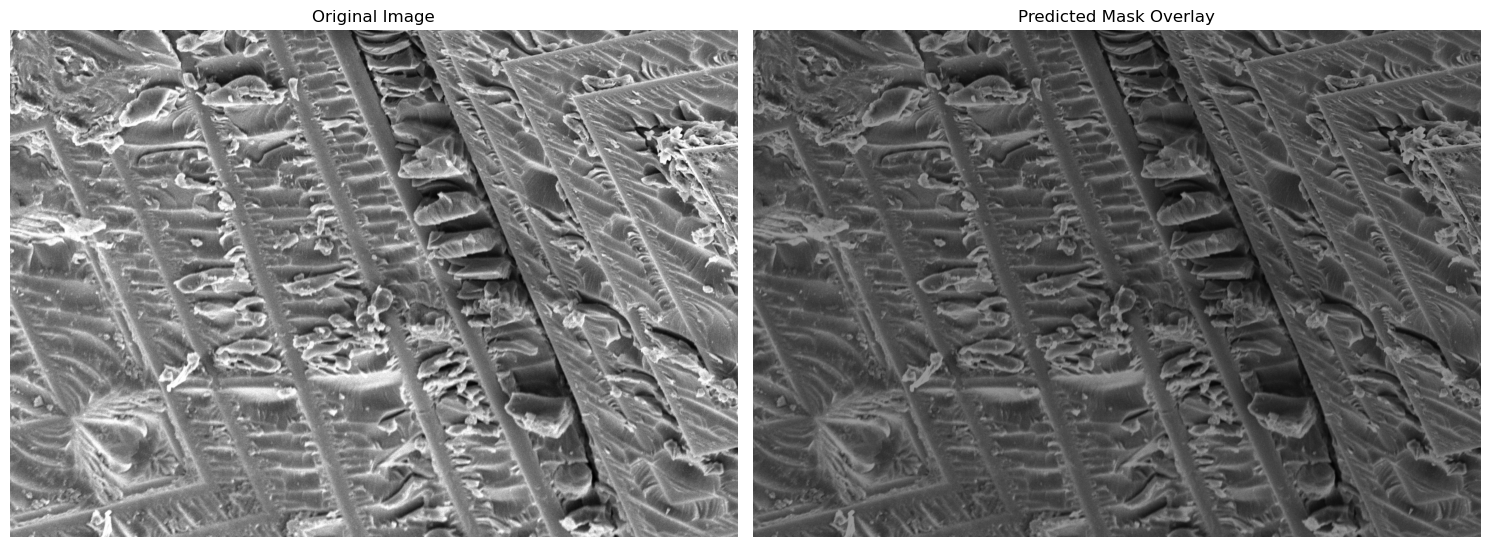

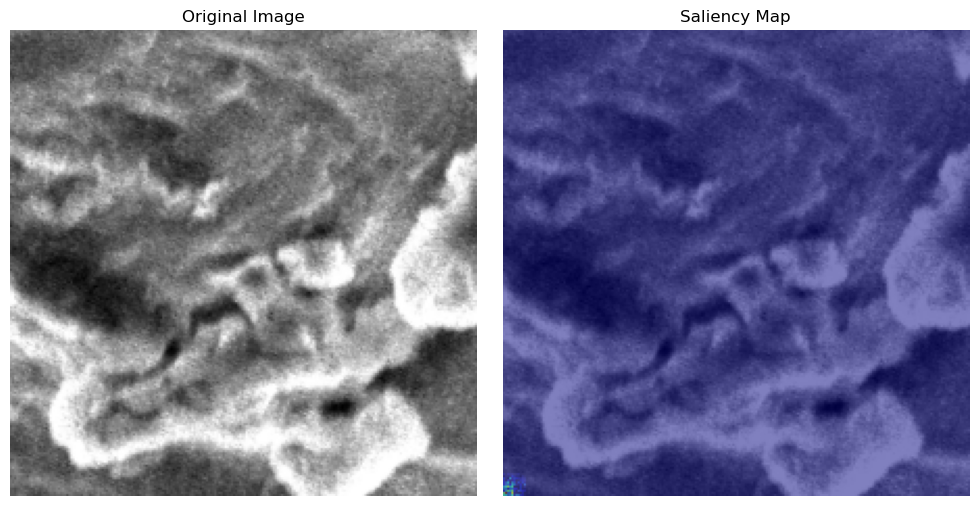

In [13]:
import tensorflow as tf

def compute_saliency_map(model, image, class_index=0):
    """ Compute saliency map using gradient of output with respect to input """
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)  # Add batch dimension

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image, training=False)
        target_class = prediction[0, :, :, class_index]  # First mask (binary output)
        loss = tf.reduce_max(target_class)  # Max activation for cusp presence

    # Gradient of loss with respect to image
    gradients = tape.gradient(loss, image)

    # Take absolute value of gradients
    saliency = tf.abs(gradients)
    saliency = tf.reduce_max(saliency, axis=-1)[0]  # Max over channels, remove batch dim
    saliency = saliency.numpy()

    # Normalize to [0, 1]
    saliency = (saliency - np.min(saliency)) / (np.max(saliency) - np.min(saliency) + 1e-10)
    return saliency

def plot_saliency(image, saliency):
    """ Overlay saliency map on original image """
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title("Original Image")
    plt.imshow(image, cmap="gray")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Saliency Map")
    plt.imshow(image, cmap="gray")
    plt.imshow(saliency, cmap="jet", alpha=0.5)
    plt.axis("off")

    plt.tight_layout()
    plt.show()

# Compute and plot saliency map on a test patch
patch = large_image[200:424, 200:424]  # Example patch
patch = patch.astype(np.float32) / 255.0
patch = np.expand_dims(patch, axis=-1)  # Add channel dimension

saliency = compute_saliency_map(model, patch)
plot_saliency(patch[:, :, 0], saliency)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━

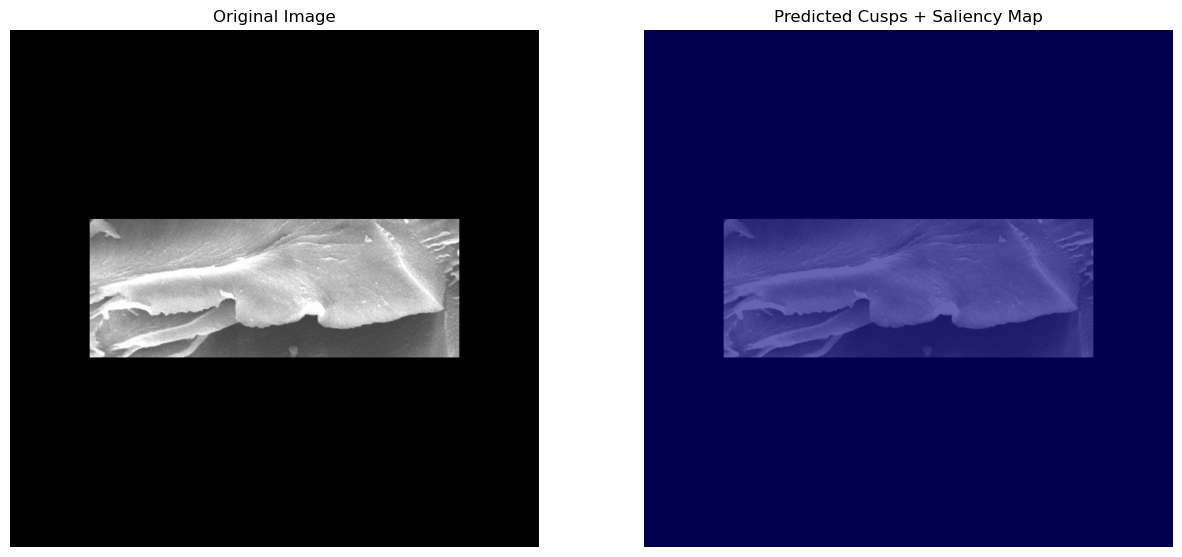

In [23]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
large_image = cv2.imread("/Users/rfalcao/Documents/FYP/ManualSegmentationAnns/padded/images/cusp_13.jpg", cv2.IMREAD_GRAYSCALE)


def sliding_window(image, window_size=(870, 851), stride=(435, 425)):
    h, w = image.shape
    window_h, window_w = window_size
    stride_h, stride_w = stride
    windows = []
    positions = []
    
    for y in range(0, h - window_h + 1, stride_h):
        for x in range(0, w - window_w + 1, stride_w):
            window = image[y:y+window_h, x:x+window_w]
            windows.append(window)
            positions.append((x, y))
    
    return windows, positions

def compute_saliency_map(model, image):
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=0)

    with tf.GradientTape() as tape:
        tape.watch(image)
        prediction = model(image, training=False)
        target = tf.reduce_max(prediction[0])  # Max activation
    
    gradients = tape.gradient(target, image)
    saliency = tf.reduce_max(tf.abs(gradients), axis=-1)[0].numpy()
    saliency = (saliency - np.min(saliency)) / (np.max(saliency) + 1e-10)
    return saliency

def plot_results(image, masks, saliency_maps, positions, window_size):
    overlay = np.zeros_like(image, dtype=np.float32)
    
    for mask, saliency, (x, y) in zip(masks, saliency_maps, positions):
        if np.max(mask) > 0.5:
            saliency_resized = cv2.resize(saliency, window_size[::-1])
            overlay[y:y+window_size[0], x:x+window_size[1]] += saliency_resized
    
    overlay = (overlay - np.min(overlay)) / (np.max(overlay) + 1e-10)
    
    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(image, cmap='gray')
    plt.imshow(overlay, cmap='jet', alpha=0.6)
    plt.title("Predicted Cusps + Saliency Map")
    plt.axis("off")
    
    plt.show()

# Sliding window
windows, positions = sliding_window(large_image, window_size=(224, 224),stride=(112, 112))
masks = []
saliency_maps = []

for window in windows:
    window = window.astype(np.float32) / 255.0
    window_resized = cv2.resize(window, (224, 224))  # Resize for ResNet
    window_resized = np.expand_dims(window_resized, axis=-1)  # Add channel
    
    # Predict mask
    mask = model.predict(np.expand_dims(window_resized, axis=0))[0]
    masks.append(mask)
    
    # Saliency map
    saliency = compute_saliency_map(model, window_resized)
    saliency_maps.append(saliency)

# Plot results
plot_results(large_image, masks, saliency_maps, positions, (870, 851))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step


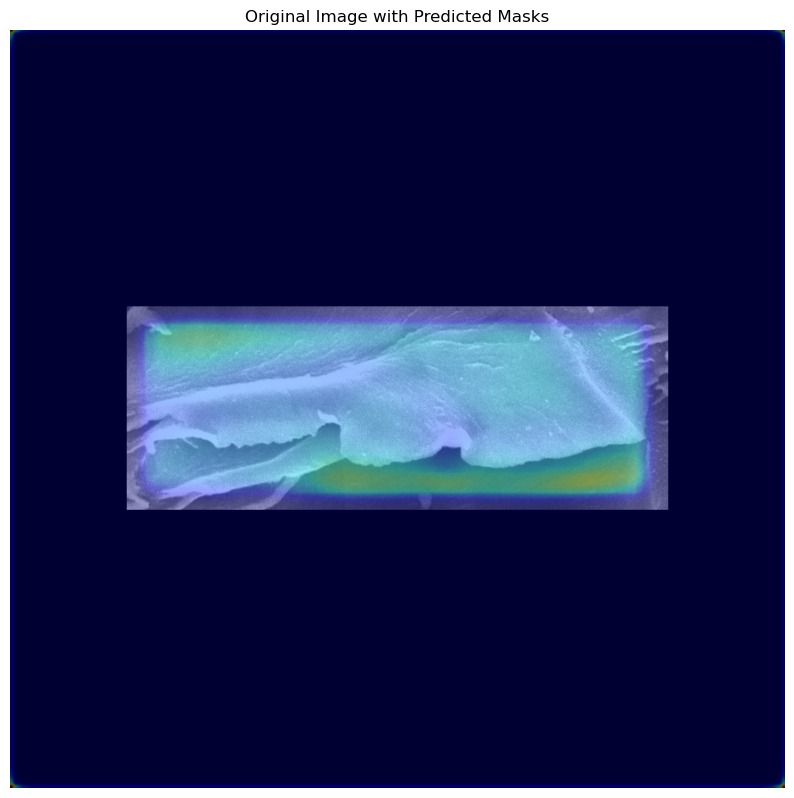

In [24]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2

def predict_full_image(image, model, target_size=(224, 224)):
    """Resize image, predict mask, and resize mask back to original size."""
    original_size = image.shape[:2]
    
    # Normalize and add channel + batch dimensions
    resized_image = cv2.resize(image, target_size)
    resized_image = np.expand_dims(resized_image, axis=-1)  # Add channel dimension
    resized_image = np.expand_dims(resized_image, axis=0)   # Add batch dimension
    resized_image = resized_image.astype(np.float32) / 255.0
    
    # Predict mask
    predicted_mask = model.predict(resized_image)[0, :, :, 0]
    
    # Resize mask back to original image size
    predicted_mask = cv2.resize(predicted_mask, (original_size[1], original_size[0]))
    
    return predicted_mask

# Perform prediction
predicted_mask = predict_full_image(large_image, model)

# Visualize the result
plt.figure(figsize=(10, 10))
plt.imshow(large_image, cmap='gray')
plt.imshow(predicted_mask, cmap='jet', alpha=0.4)  # Overlay with transparency
plt.title("Original Image with Predicted Masks")
plt.axis("off")
plt.show()
